In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv(r"C:\Users\ALVI\Downloads\Compressed\1014_4361_bundle_archive\Bangla_NER_Dataset.csv", encoding="UTF-8")


In [2]:
data = data.fillna(method="ffill")


In [3]:
data.tail(10)


,Sentence #,Word,Tag
297407,Sentence: 22145,ফিরে,O
297408,Sentence: 22145,এসে,O
297409,Sentence: 22145,ভালোবাসা,O
297410,Sentence: 22145,নিয়েই,O
297411,Sentence: 22145,নতুন,O
297412,Sentence: 22145,করে,O
297413,Sentence: 22145,শুরু,O
297414,Sentence: 22145,হোক,O
297415,Sentence: 22145,পথ,O
297416,Sentence: 22145,চলা,O


In [4]:
words = list(set(data["Word"].values))
n_words = len(words); n_words


34236

In [5]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags


17

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [7]:
getter = SentenceGetter(data)


In [8]:
sent = getter.get_next()


In [9]:
print(sent)


[('বাংলাদেশে', 'B-geo'), ('কক্সবাজার', 'B-geo'), ('এলাকায়', 'O'), ('রোহিঙ্গাদের', 'B-gpe'), ('জন্য', 'O'), ('নির্ধারিত', 'O'), ('আশ্রয়', 'O'), ('শিবিরের', 'O'), ('বাইরে', 'O'), ('বেরুলে', 'O'), ('তাদের', 'O'), ('গ্রেপ্তার', 'O'), ('করা', 'O'), ('হবে', 'O'), ('বলে', 'O'), ('জানিয়েছেন', 'O'), ('পুলিশের', 'O'), ('মহাপরিদর্শক', 'O'), ('একেএম', 'B-per'), ('শহীদুল', 'I-per'), ('হক', 'I-per')]


In [10]:
sentences = getter.sentences


In [11]:
max_len = 75
max_len_char = 10


In [12]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}


In [13]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]


In [14]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')


In [15]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


144


In [16]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0


In [17]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
    



In [18]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]


In [19]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [20]:
from sklearn.model_selection import train_test_split


In [21]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)


In [22]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


In [23]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)


In [24]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])


In [25]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 10, 10)   1460        input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 20)       684760      input_1[0][0]                    
______________________________________________________________________________________________

In [26]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=6, validation_split=0.1, verbose=1)


Epoch 1/6
561/561 [==============================] - 107s 173ms/step - loss: 0.2269 - acc: 0.8144 - val_loss: 0.0912 - val_acc: 0.8343
Epoch 2/6
561/561 [==============================] - 93s 166ms/step - loss: 0.0837 - acc: 0.8328 - val_loss: 0.0716 - val_acc: 0.8681
Epoch 3/6
561/561 [==============================] - 95s 169ms/step - loss: 0.0576 - acc: 0.8981 - val_loss: 0.0512 - val_acc: 0.9134
Epoch 4/6
561/561 [==============================] - 95s 170ms/step - loss: 0.0387 - acc: 0.9364 - val_loss: 0.0430 - val_acc: 0.9349
Epoch 5/6
561/561 [==============================] - 97s 173ms/step - loss: 0.0294 - acc: 0.9560 - val_loss: 0.0387 - val_acc: 0.9404
Epoch 6/6
561/561 [==============================] - 112s 200ms/step - loss: 0.0232 - acc: 0.9643 - val_loss: 0.0359 - val_acc: 0.9449


In [27]:
hist = pd.DataFrame(history.history)


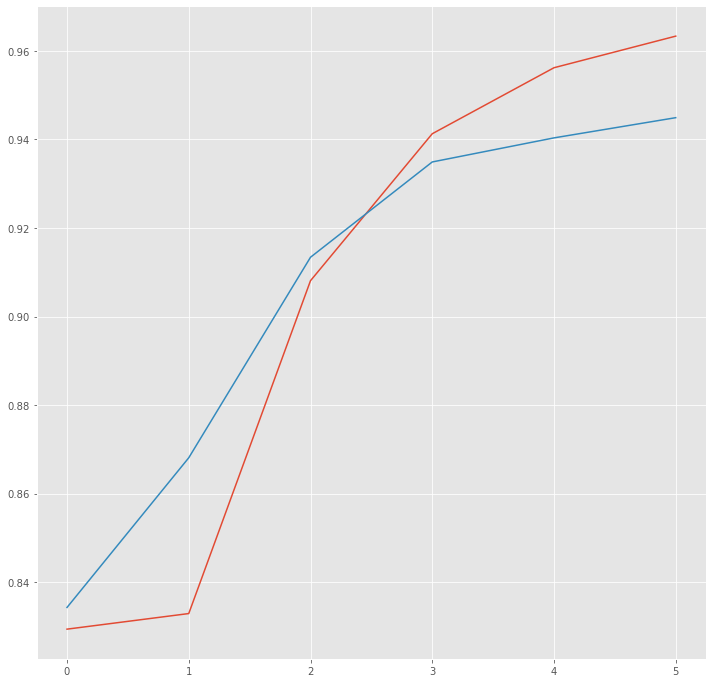

In [28]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [29]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])


In [30]:
i = 1925
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
এমন            : O     O
প্রশ্নে        : O     O
আনিসুল         : B-per B-per
হক             : I-per I-per
বলেন           : O     O
প্রধানমন্ত্রী  : B-per B-per
শেখ            : I-per I-per
হাসিনা         : I-per I-per
মানবিক         : O     O
বিষয়           : O     O
বিবেচনা        : O     O
করে            : O     O
রোহিঙ্গাদের    : B-gpe B-gpe
এ              : O     O
দেশে           : O     O
আশ্রয়          : O     O
দিয়েছেন        : O     O


In [31]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

# def pred2label(pred, orig_test=False):
#     out = []
#     for pred_i in pred:
#         out_i = []
#         for p in pred_i:
#             if orig_test:
#                 p_i = p
#             else:
#                 p_i = np.argmax(p)
#                 out_i.append(idx2tag[p_i].replace("PAD", "O"))
#         out.append(out_i)
#     return out
   
# pred_labels = pred2label(test_pred)
# test_labels = pred2label(y_te)


In [32]:
test_pred = model.predict([X_word_te,
                           np.array(X_char_te).reshape((len(X_char_te),
                                                        max_len, max_len_char))], verbose=1)

70/70 [==============================] - 3s 36ms/step


In [33]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [34]:
def pred2label(pred, orig_test=False):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            if orig_test:
                p_i = p
            else:
                p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te, orig_test=True)

In [35]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 72.0%


In [36]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      tim       0.82      0.82      0.82       472
      per       0.74      0.67      0.71       987
      geo       0.82      0.79      0.81       983
      org       0.46      0.55      0.50       594
      gpe       0.95      0.90      0.93       242
      art       0.67      0.06      0.11        34
      eve       0.00      0.00      0.00        41
      nat       0.00      0.00      0.00         3

micro avg       0.73      0.71      0.72      3356
macro avg       0.73      0.71      0.72      3356



In [37]:
test_pred[0]

array([[2.07310222e-07, 2.84809828e-01, 4.68773396e-06, ...,
        2.07352329e-07, 6.96361226e-08, 9.44469502e-05],
       [1.48071688e-08, 1.42695636e-01, 8.17967475e-07, ...,
        1.81950668e-07, 1.31838185e-08, 1.53303918e-05],
       [7.30798178e-09, 1.13881409e-01, 3.14340866e-07, ...,
        2.79792602e-07, 2.22448504e-09, 6.67696349e-06],
       ...,
       [4.70613718e-01, 5.02320349e-01, 4.58317488e-01, ...,
        4.43304986e-01, 4.66832101e-01, 4.34729606e-01],
       [4.70613718e-01, 5.02320349e-01, 4.58317488e-01, ...,
        4.43304986e-01, 4.66832101e-01, 4.34729606e-01],
       [4.70613718e-01, 5.02320349e-01, 4.58317488e-01, ...,
        4.43304986e-01, 4.66832101e-01, 4.34729606e-01]], dtype=float32)

In [38]:
y_te[0]

array([ 1,  1,  1, 15,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [39]:
for word, label, pred in zip(X_word_te[0],y_te[0], test_pred[0]):
    print(idx2word[word],idx2tag[label],idx2tag[np.argmax(pred)])

আরো O O
উন্নয়নের O O
জন্য O O
নূর B-per B-per
ভাইকে O O
আবারও O O
নির্বাচিত O O
করবে O O
এলাকার O O
সর্বস্তরের O O
মানুষ O O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
PAD PAD O
